In [540]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

In [541]:
def none_insert(value):
    '''функция заменяет пустые значения, NaN, nan на более удобное None'''
    if value == '':
        return None
    if value == 'NaN':
        return None
    if value == 'nan':
        return None
    else:
        return value

In [542]:
def not_range_values(list_of_ranges, value):
    '''Заменяет значения в колонках которые не принадллежат тем которые заданы в опроснике на None'''
    if str(value) in list_of_ranges:
        return value
    else:
        return None

In [543]:
def outlier_quant(data, column_name):
    '''функция анализирует выбросы и выводит гистограмму, на которой они отображаются. в качествевыходных данных
    используется статистические параметры'''

    print('')
    print('СТАТИСТИКИ и РЕЗУЛЬТАТЫ АНАЛИЗА ВЫБРОСОВ')
    median = data[column_name].median()
    IQR = data[column_name].quantile(0.75) - data[column_name].quantile(0.25)
    perc25 = data[column_name].quantile(0.25)
    perc75 = data[column_name].quantile(0.75)
    low_range = perc25 - 1.5*IQR
    high_range = perc75 + 1.5*IQR
    print('медиана: {},'.format(median), '25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

    data[column_name].loc[data[column_name].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(
        alpha=0.85, bins=16, range=(data[column_name].min(), data[column_name].max()), label='IQR')
    data[column_name].hist(alpha=0.20, bins=16, range=(
        data[column_name].min(), data[column_name].max()), label='outliers')
    plt.legend()
    return median, IQR, perc25, perc75, low_range, high_range

In [544]:
def boxplot_ttest(df, col_name_values, col_name_param):
    '''Статистическое сравнение t-тестом Стьюдента и построение box plot для столбцов с двумя категориями'''

    if df[col_name_param].dropna().nunique() == 2:
        uniq_bins = df[col_name_param].dropna().unique()
        # display(uniq_bins)
        #display(list(df[(df[col_name_param] == uniq_bins[1])][col_name_values].dropna()))
        stat_result = ttest_ind(df.loc[(df[col_name_param] == uniq_bins[0])][col_name_values].dropna(
        ), df.loc[(df[col_name_param] == uniq_bins[1])][col_name_values].dropna())
        if stat_result.pvalue <= 0.05:
            print("p-value: {};".format(round(stat_result[1], 10)), 'Значения в колонке ',
                  col_name_param, 'достоверно различаются (alpha = 0.05)')
        else:
            print("p-value: {};".format(round(stat_result[1], 10)), 'Значения в колонке ',
                  col_name_param, 'достоверно не различаются (alpha = 0.05)')
        sns.boxplot(x=col_name_param, y=col_name_values, data=df)
        return stat_result
    else:
        return 0

In [545]:
def boxplot_ttest_choise(df, col_name_values, col_name_param, uniq_bins):
    '''Статистическое сравнение t-тестом Стьюдента и построение box plot для 
    выбранных нами столбцов из uniq_bins'''

    sns.boxplot(x=col_name_param, y=col_name_values,
                data=df.loc[df[col_name_param].isin(uniq_bins)])
    combinations_all = list(combinations(uniq_bins, 2))
    # print(len(combinations_all))
    for comb in combinations_all:
        # print(comb)
        stat_result = ttest_ind(df.loc[(df[col_name_param] == comb[0])][col_name_values].dropna(
        ), df.loc[(df[col_name_param] == comb[1])][col_name_values].dropna())
        # print(stat_result.pvalue)
        if stat_result.pvalue <= 0.05/len(combinations_all):
            print("p-value: {};".format(round(stat_result[1], 10)), 'Значения', "{}".format(comb[0]), 'и', "{}".format(
                comb[1]), 'в колонке ', col_name_param, 'достоверно различаются (alpha = 0.05)')

    return stat_result

In [546]:
def outliers_del(x, low_range, high_range):
    if (x < low_range) or (x > high_range):
        return None
    else:
        return x

In [643]:
def pair_column_ttest(df, list_of_columns, col_name_values):
    '''функция сравнивает все комбинации двух номинативных столбцов с двумя значениями с помощью ttest
    Иначе говоря если в данном примере мы берем колонки школа и пол, то мы сравниваем между собой:
    девочек из школы 1, девочек из школы 2, мальчиков из школы 1, и мальчиков из школы 2 между собой'''

    combinations_columns = list(combinations(list_of_columns, 2))
    for column_combination in combinations_columns:  # комбинация из двух для всех колонок
        # print(column_combination)
        uniq_bins_first = df[column_combination[0]].dropna().unique()
        uniq_bins_second = df[column_combination[1]].dropna().unique()
        combs_list = [[uniq_bins_first[0], uniq_bins_second[0]], [uniq_bins_first[0], uniq_bins_second[1]]  # комбинация значений в двух колонках
                      , [uniq_bins_first[1], uniq_bins_second[0]], [uniq_bins_first[1], uniq_bins_second[1]]]
        combinations_combs = list(combinations(combs_list, 2))
        # print(combinations_combs)

        ttest_list = []
        for comb_combinations in combinations_combs:  # различные комбинации "комбинаций в двух колонках"
            first_dat = df.loc[(df[column_combination[0]] == comb_combinations[0][0]) & (
                df[column_combination[1]] == comb_combinations[0][1])][col_name_values].dropna()
            second_dat = df.loc[(df[column_combination[0]] == comb_combinations[1][0]) & (
                df[column_combination[1]] == comb_combinations[1][1])][col_name_values].dropna()
            # проверка на количество получаемых колонок, если значений в них мало то не проводим статистический анализ
            if len(first_dat > 25) and len(second_dat > 25):
                stat_result = ttest_ind(first_dat, second_dat)
                new_list_line = [comb_combinations, stat_result]
                ttest_list.append(new_list_line)

        for line in ttest_list:
            # с поправкой бонферони
            if (line[1].pvalue <= 0.05/len(ttest_list)) & (line[1].statistic < 0):
                print("p-value: {};".format(round(line[1].pvalue, 5)), "в столбцах {}".format(column_combination),
                      "значения {} ".format(line[0][0]), "достоверно меньше значений {}".format(line[0][1]))
            # с поправкой бонферони
            if (line[1].pvalue <= 0.05/len(ttest_list)) & (line[1].statistic > 0):
                print("p-value: {};".format(round(line[1].pvalue, 5)), "в столбцах {}".format(column_combination),
                      "значения {} ".format(line[0][0]), "достоверно больше значений {}".format(line[0][1]))

    return None

In [547]:
data = pd.read_csv('stud_math.csv')
display(data.head(10))

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


In [548]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

None

## Общий план

Разобьем анализ данных на следующие этапы:
    Этап 1 - Очистка, предобработка и анализ каждого каждого в отдельности. Столбцы содрежащие номинативные данные обработать с помощью сравнительного анализа стьюдента сразу. Создать предварительный список столбцов которые требуется убрать из анализа.
    Этап 2 - Корреляционный анализ численных значений.
    Этап 3 - Совместный попарный анализ столбцов c номинативными значениями с двуми значениями (например yes/no) для финального отброра данных

## Этап 1 очистка, предобработака, стат. анализ

### баллы по гос экзамену предобработка

,score
50.0,54
55.0,46
0.0,37
75.0,33
65.0,31
40.0,31
60.0,31
70.0,27
45.0,27
80.0,16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   score   389 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB

СТАТИСТИКИ и РЕЗУЛЬТАТЫ АНАЛИЗА ВЫБРОСОВ
медиана: 55.0, 25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


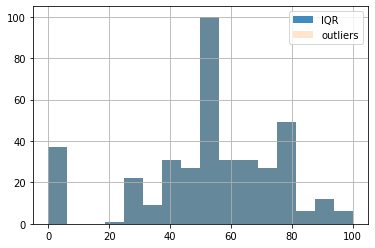

In [549]:
display(pd.DataFrame(data.score.value_counts()))
data.loc[:, ['score']].info()
data.score = data.score.apply(lambda x: none_insert(x))
stats_score = outlier_quant(data, 'score')

Скорее всего сисьема 100 бальная за экзамен. Не смотря на то, что 0 входит в границы выбросов его необходимо исключить из рассмотрения так как в значения с 0 могут входить различные группы - например - тот кто не пришел на тестирование или люди которые не подписали работу или намеренно запоровшие. Указывает на это полное отсутсвие значений в промежутке от нуля до 20. Следовательно из дальнейшего анализа убираем значения score = 0.0


СТАТИСТИКИ и РЕЗУЛЬТАТЫ АНАЛИЗА ВЫБРОСОВ
медиана: 55.0, 25-й перцентиль: 45.0, 75-й перцентиль: 70.0, IQR: 25.0,  Границы выбросов: [7.5, 107.5].


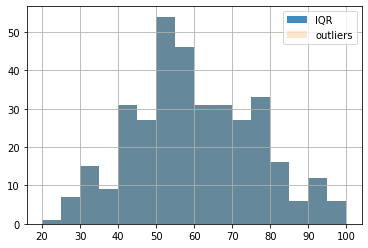

In [550]:
data.score = data.score.apply(lambda x: None if x == 0 else x)
stats_score = outlier_quant(data, 'score')

В новом датафрейме без значений за экзамен = 0 отсутствуют выбросы (распределение близкое к нормальное)

### Школа

In [551]:
display(pd.DataFrame(data.school.value_counts()))
data.loc[:, ['school']].info()

,school
GP,349
MS,46


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   school  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Наша выборка состоит из учеников двух школ.
Некорректные значения отсутствуют

p-value: 0.1427891364; Значения в колонке  school достоверно не различаются (alpha = 0.05)


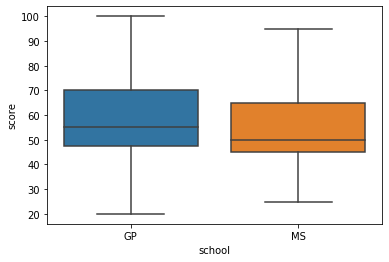

In [552]:
stat_results = boxplot_ttest(data, 'score', 'school')

Значение результатов экзамена не зависит от школы. Из дальнейшего анализа данные могут быть убраны

In [553]:
#del data['school']

### Пол 

In [554]:
display(pd.DataFrame(data.sex.value_counts()))
data.loc[:, ['sex']].info()

,sex
F,208
M,187


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Некорректные и/или пропущенные значения в столбце с полом учеников отсутствуют

p-value: 0.0548162943; Значения в колонке  sex достоверно не различаются (alpha = 0.05)


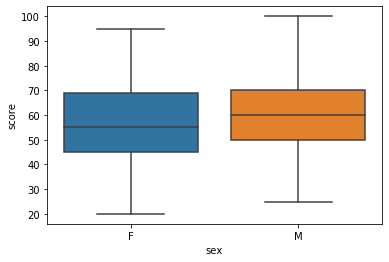

In [555]:
stat_results = boxplot_ttest(data, 'score', 'sex')

Существует тренд к достоверно более высоким значениям оценки у мальчиков. Оставляем данные 

### Возраст

In [556]:
display(pd.DataFrame(data.age.value_counts()))
data.loc[:, ['age']].info()

,age
16,104
17,98
18,82
15,82
19,24
20,3
22,1
21,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     395 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB



СТАТИСТИКИ и РЕЗУЛЬТАТЫ АНАЛИЗА ВЫБРОСОВ
медиана: 17.0, 25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


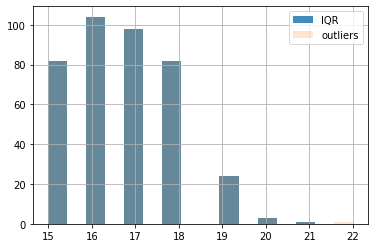

In [557]:
data.age = data.age.apply(lambda x: none_insert(x))
stats_age = outlier_quant(data, 'age')

Некорректные и/или пропущенные значения в столбце с полом учеников отсутствуют
Не требует предобработки. Анализ выбросов показал что значение 22 года - является выбросом, однако значения промежутка 15-22 лет. Значение не убираем. распределение нормальное, смещенное влево. 

### Адрес

In [558]:
display(pd.DataFrame(data.address.value_counts()))
data.loc[:, ['address']].info()

,address
U,295
R,83


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


У учеников отсутствуют значения адреса. в полях есть значения  nan. требуется замена NaN на None. 
Лишние значения отсутствуют

In [559]:
data.loc[(data['address'].isnull()), 'address'] = None

p-value: 0.0109546305; Значения в колонке  address достоверно различаются (alpha = 0.05)


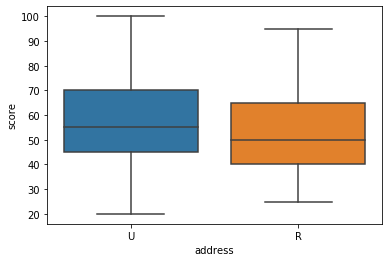

In [560]:
stat_results = boxplot_ttest(data, 'score', 'address')

Существует достоверная зависимость между тем живет ученик в городе или за городом и его успеваемостью (Что и в целом логично городские показывают более лучшие знания). Оставляем данные

### Размер семьи 

In [561]:
display(pd.DataFrame(data.famsize.value_counts()))
data.loc[:, ['famsize']].info()

,famsize
GT3,261
LE3,107


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   famsize  368 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


У некоторых учеников отсутствуют значения в этом столбце. в полях есть значения nan. требуется замена NaN на None. Лишние значения отсутствуют

p-value: 0.6456316209; Значения в колонке  famsize достоверно не различаются (alpha = 0.05)


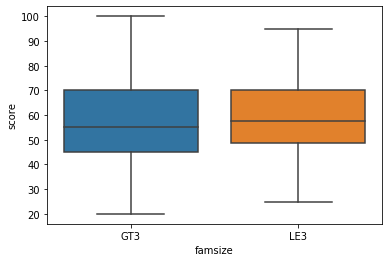

In [562]:
data.loc[(data['famsize'].isnull()), 'famsize'] = None
stat_results = boxplot_ttest(data, 'score', 'famsize')

Нет достоверных данных по влиянию количесвта людей в семье на оценки учеников. Можно убрать

In [563]:
# del(data['famsize'])

### Статус жилья с родителями

In [564]:
data.rename(columns={'Pstatus': 'pstatus'}, inplace=True)
display(pd.DataFrame(data.pstatus.value_counts()))
data.loc[:, ['pstatus']].info()

,pstatus
T,314
A,36


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pstatus  350 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


У некоторых учеников отсутствуют значения в этом столбце. в полях есть значения nan. требуется замена NaN на None. Лишние значения отсутствуют

p-value: 0.7618568739; Значения в колонке  pstatus достоверно не различаются (alpha = 0.05)


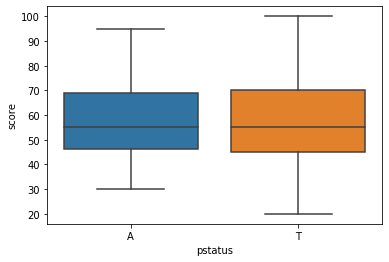

In [565]:
data.loc[(data['pstatus'].isnull()), 'pstatus'] = None
stat_results = boxplot_ttest(data, 'score', 'pstatus')

Статус совместного жилья родителей не влияет на итоговый бал. параметр может быть убран из рассмотрения.

In [566]:
# del(data['pstatus'])

### образование матери 

In [567]:
data.rename(columns={'Medu': 'medu'}, inplace=True)
display(pd.DataFrame(data.medu.value_counts()))
data.loc[:, ['medu']].info()

,medu
4.0,131
2.0,102
3.0,97
1.0,59
0.0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   medu    392 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


In [568]:
data.medu = data.medu.apply(lambda x: none_insert(x))

есть значения NaN, переделаны в None. Из анализа следует исключить значение 0.0 так как данных очень мало и можно получить ложно-отрицпательные и ложно-положительные результаты. 

p-value: 0.0003042766; Значения 1.0 и 4.0 в колонке  medu достоверно различаются (alpha = 0.05)


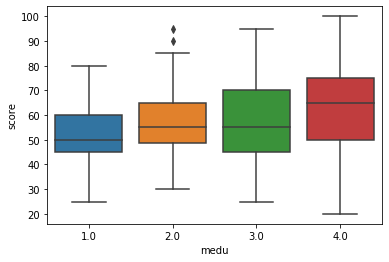

In [569]:
ttest_result = boxplot_ttest_choise(
    data, 'score', 'medu', [1.0, 2.0, 3.0, 4.0])

Колонку необходимо оставить. Логичное предположение, что дети сдают экзамены лучше если у родителей (в данном случае матери)высшее образованием, чем самое маленькое, подтверждается статистически 

### образование отца

In [570]:
data.rename(columns={'Fedu': 'fedu'}, inplace=True)
display(pd.DataFrame(data.fedu.value_counts()))
data.loc[:, ['fedu']].info()

,fedu
2.0,106
3.0,96
4.0,88
1.0,78
0.0,2
40.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fedu    371 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


In [571]:
data.fedu = data.fedu.apply(lambda x: none_insert(x))

есть значение которое не входит в список по данному критерию (40,0 - скорее всего принадлежит к 4 группе, но все равно не будем лезть в данные)

In [572]:
data.fedu = data.fedu.apply(lambda x: not_range_values(
    ['0.0', '1.0', '2.0', '3.0', '4.0'], x))
display(pd.DataFrame(data.fedu.value_counts()))
data.loc[:, ['fedu']].info()

,fedu
2.0,106
3.0,96
4.0,88
1.0,78
0.0,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fedu    370 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


p-value: 0.0033842377; Значения 1.0 и 4.0 в колонке  fedu достоверно различаются (alpha = 0.05)


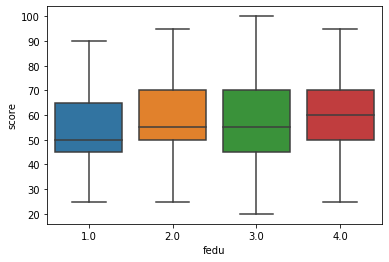

In [573]:
ttest_result = boxplot_ttest_choise(
    data, 'score', 'fedu', [1.0, 2.0, 3.0, 4.0])

Аналогично с пунктом образования матери 

### работа матери

In [574]:
data.rename(columns={'Mjob': 'mjob'}, inplace=True)
display(pd.DataFrame(data.mjob.value_counts()))
data.loc[:, ['mjob']].info()

,mjob
other,133
services,98
at_home,58
teacher,55
health,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mjob    376 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


In [575]:
data.fedu = data.mjob.apply(lambda x: none_insert(x))

есть значения NaN, переделаны в None

p-value: 0.0017949218; Значения other и health в колонке  mjob достоверно различаются (alpha = 0.05)
p-value: 0.002798206; Значения at_home и health в колонке  mjob достоверно различаются (alpha = 0.05)


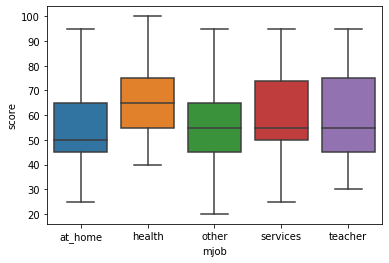

In [576]:
ttest_result = boxplot_ttest_choise(
    data, 'score', 'mjob', ['other', 'services', 'at_home', 'teacher', 'health'])

У детей, где мать работает в сфере здравоохранения, значения за экзамен больше чем в семьях где мать не работает или работает в разной группе. Довльно странно, но добавляем в финальный анализ

### работа отца

In [577]:
data.rename(columns={'Fjob': 'fjob'}, inplace=True)
display(pd.DataFrame(data.fjob.value_counts()))
data.loc[:, ['fjob']].info()

,fjob
other,197
services,102
teacher,29
at_home,16
health,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fjob    359 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


In [578]:
data.fjob = data.fjob.apply(lambda x: none_insert(x))

есть значения NaN, переделаны в None

p-value: 0.0027785789; Значения other и teacher в колонке  fjob достоверно различаются (alpha = 0.05)
p-value: 0.0025163188; Значения services и teacher в колонке  fjob достоверно различаются (alpha = 0.05)


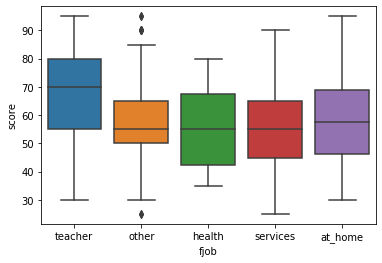

In [579]:
ttest_result = boxplot_ttest_choise(
    data, 'score', 'fjob', ['other', 'services', 'at_home', 'teacher', 'health'])

У тех детей которых отец работает учителем значнеия за экзамены выше некоторых других групп. Во-первых учителей в группе мало. Однако это может быть логично - часто мужчины преподаватели именно 

### причина выбора школы

In [580]:
display(pd.DataFrame(data.reason.value_counts()))
data.loc[:, ['reason']].info()
data.reason = data.reason.apply(lambda x: none_insert(x))

,reason
course,137
home,104
reputation,103
other,34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


есть значения NaN, переделаны в None

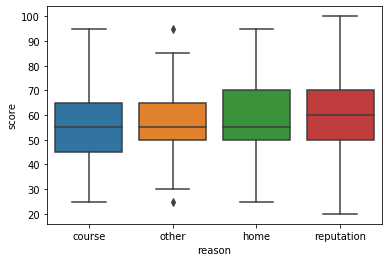

In [581]:
ttest_result = boxplot_ttest_choise(
    data, 'score', 'reason', ['other', 'course', 'home', 'teacher', 'reputation'])

ПРичина выбора школы не влияет на оценку.

In [582]:
del data['reason']

### опекун

In [583]:
display(pd.DataFrame(data.guardian.value_counts()))
data.loc[:, ['guardian']].info()

,guardian
mother,250
father,86
other,28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guardian  364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


In [584]:
data.guardian = data.guardian.apply(lambda x: none_insert(x))

есть значения NaN, переделаны в None

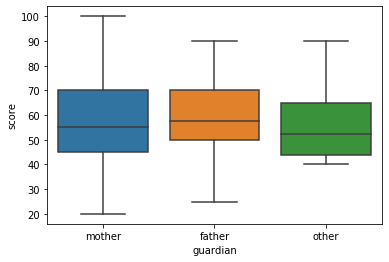

In [585]:
ttest_result = boxplot_ttest_choise(data, 'score', 'guardian', [
                                    'other', 'mother', 'father'])

опекун не влияет на результаты экзаменов. можно убрать из рассмотрения.

In [586]:
del data['guardian']

### время до школы

In [587]:
display(pd.DataFrame(data.traveltime.value_counts()))
data.loc[:, ['traveltime']].info()

,traveltime
1.0,242
2.0,96
3.0,22
4.0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   traveltime  367 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


In [588]:
data.traveltime = data.traveltime.apply(lambda x: none_insert(x))

есть значения NaN, переделаны в None. Из статистического анализа следует убрать значения 4.0 - их слишком мало.  

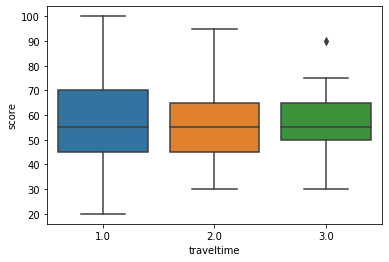

In [589]:
ttest_result = boxplot_ttest_choise(
    data, 'score', 'traveltime', [1.0, 2.0, 3.0])

время до школы не влияет на экзамены. Можно убрать столбец из рассмотрения. 

In [590]:
del data['traveltime']

### время на учебу 

In [591]:
display(pd.DataFrame(data.studytime.value_counts()))
data.loc[:, ['studytime']].info()

,studytime
2.0,194
1.0,103
3.0,64
4.0,27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   studytime  388 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


In [592]:
data.studytime = data.studytime.apply(lambda x: none_insert(x))

есть значения NaN, переделаны в None

p-value: 0.00232787; Значения 2.0 и 3.0 в колонке  studytime достоверно различаются (alpha = 0.05)


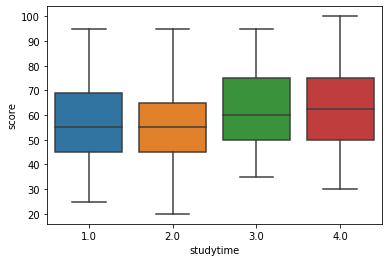

In [593]:
ttest_result = boxplot_ttest_choise(
    data, 'score', 'studytime', [1.0, 2.0, 3.0, 4.0])

Из графиков очевидно, что те кто тратят больше времени на учебу (от 5 часов) более успешны. Отчасти подтверждается данными статистического анализа. Оставляем в рассмотрении данный параметр.

### внеучебные неудачи

In [594]:
display(pd.DataFrame(data.failures.value_counts()))
data.loc[:, ['failures']].info()

,failures
0.0,293
1.0,49
2.0,16
3.0,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   failures  373 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


In [595]:
data.failures = data.failures.apply(lambda x: none_insert(x))

p-value: 0.0010152789; Значения 1.0 и 0.0 в колонке  failures достоверно различаются (alpha = 0.05)
p-value: 0.0018497001; Значения 2.0 и 0.0 в колонке  failures достоверно различаются (alpha = 0.05)
p-value: 0.0004620843; Значения 3.0 и 0.0 в колонке  failures достоверно различаются (alpha = 0.05)


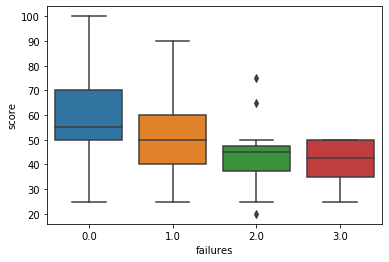

In [596]:
ttest_result = boxplot_ttest_choise(
    data, 'score', 'failures', [1.0, 2.0, 3.0, 0.0])

###  доп образовательная поддержка

In [597]:
display(pd.DataFrame(data.schoolsup.value_counts()))
data.loc[:, ['schoolsup']].info()

,schoolsup
no,335
yes,51


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   schoolsup  386 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


p-value: 2.8153e-06; Значения в колонке  schoolsup достоверно различаются (alpha = 0.05)


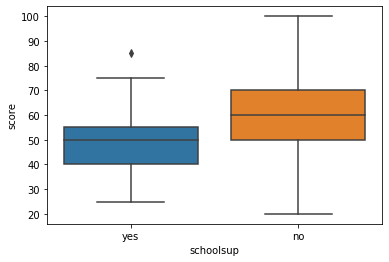

In [598]:
data.loc[(data['schoolsup'].isnull()), 'schoolsup'] = None
stat_results = boxplot_ttest(data, 'score', 'schoolsup')

Дети без дополнительной образовательной поддержки показывают результаты лучше, чем с ней (возможно в данном случае образовательная поддержка оказывается совсем отстающим ученикам?). Несомненно оставляем этот параметр.

###  семейная образовательная поддержка

In [599]:
display(pd.DataFrame(data.famsup.value_counts()))
data.loc[:, ['famsup']].info()

,famsup
yes,219
no,137


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   famsup  356 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


p-value: 0.406309665; Значения в колонке  famsup достоверно не различаются (alpha = 0.05)


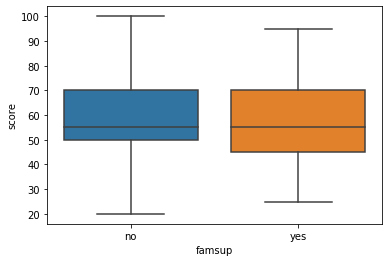

In [600]:
data.loc[(data['famsup'].isnull()), 'famsup'] = None
stat_results = boxplot_ttest(data, 'score', 'famsup')

поддержка образовательная семьи не влияет на результаты экзамена. Можем убрать. 

In [601]:
#del data['famsup']

###  дополнительные платные занятия

In [602]:
display(pd.DataFrame(data.paid.value_counts()))
data.loc[:, ['paid']].info()

,paid
no,200
yes,155


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   paid    355 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


p-value: 0.6963358441; Значения в колонке  paid достоверно не различаются (alpha = 0.05)


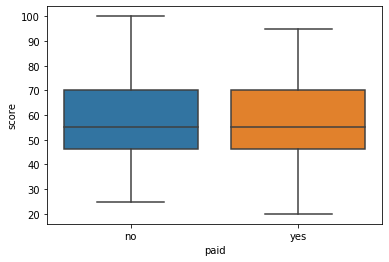

In [603]:
data.loc[(data['paid'].isnull()), 'paid'] = None
stat_results = boxplot_ttest(data, 'score', 'paid')

дополнительные платные занятия не исправляют  ситуации. Можем убрать. 

In [604]:
#del data['paid']

###  дополнительные внеучебные занятия

In [605]:
display(pd.DataFrame(data.activities.value_counts()))
data.loc[:, ['activities']].info()

,activities
yes,195
no,186


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  381 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


p-value: 0.2698473956; Значения в колонке  activities достоверно не различаются (alpha = 0.05)


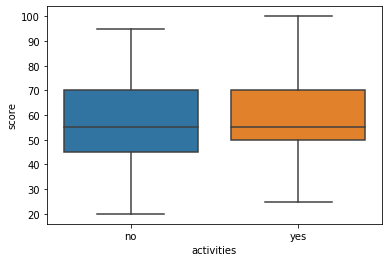

In [606]:
data.loc[(data['activities'].isnull()), 'activities'] = None
stat_results = boxplot_ttest(data, 'score', 'activities')

дополнительные внеучебные занятия не влияют на финальные баллы на экзамене. Можем убрать. 

In [607]:
#del data['activities']

###  посещал детский сад

In [608]:
display(pd.DataFrame(data.nursery.value_counts()))
data.loc[:, ['nursery']].info()

,nursery
yes,300
no,79


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nursery  379 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


p-value: 0.582833512; Значения в колонке  nursery достоверно не различаются (alpha = 0.05)


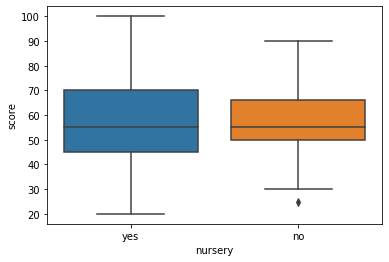

In [609]:
data.loc[(data['nursery'].isnull()), 'nursery'] = None
stat_results = boxplot_ttest(data, 'score', 'nursery')

Посещение детского сада не влияет на оценки. Можем убрать. 

In [610]:
#del data['nursery']

###  хочет получить высшее образование

In [611]:
display(pd.DataFrame(data.higher.value_counts()))
data.loc[:, ['higher']].info()

,higher
yes,356
no,19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   higher  375 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


p-value: 0.0560415517; Значения в колонке  higher достоверно не различаются (alpha = 0.05)


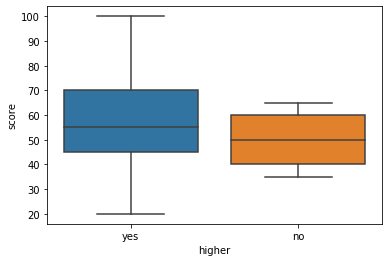

In [612]:
data.loc[(data['higher'].isnull()), 'higher'] = None
stat_results = boxplot_ttest(data, 'score', 'higher')

Достоверного различия нет, однако существует логичный тренд - стремление получить высшее образование стимулирует к учебе. Одноко 1) К сожалению очень маленькое колличество детей ответило, что они не хотят получить высшее образование 2) судя по разбросу значений в колонке - желание получить образование не равно прикладываемым усилиям. Убираем из рассмотрения

In [641]:
#del data['higher']

###  наличие интернета дома

In [613]:
display(pd.DataFrame(data.internet.value_counts()))
data.loc[:, ['internet']].info()

,internet
yes,305
no,56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   internet  361 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


p-value: 0.2232445088; Значения в колонке  internet достоверно не различаются (alpha = 0.05)


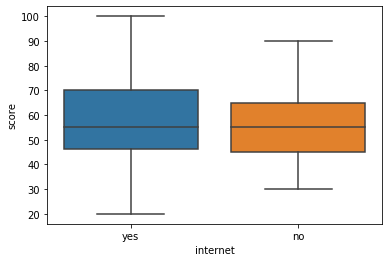

In [614]:
data.loc[(data['internet'].isnull()), 'internet'] = None
stat_results = boxplot_ttest(data, 'score', 'internet')

наличие интернета не влияет на оценки. Можем убрать. 

In [615]:
#del data['internet']

###  наличие романтических отношений

In [616]:
display(pd.DataFrame(data.romantic.value_counts()))
data.loc[:, ['romantic']].info()

,romantic
no,240
yes,124


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   romantic  364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


p-value: 0.2668414509; Значения в колонке  romantic достоверно не различаются (alpha = 0.05)


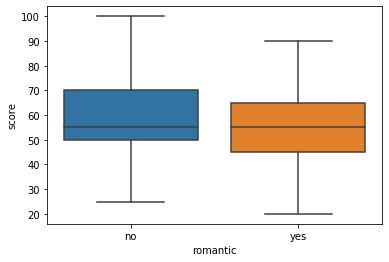

In [617]:
data.loc[(data['romantic'].isnull()), 'romantic'] = None
stat_results = boxplot_ttest(data, 'score', 'romantic')

Романтические отношения не влияют на успеваемость. Параметр можно убрать. 

In [618]:
#del data['romantic']

###  Семейные отношения

In [619]:
display(pd.DataFrame(data.famrel.value_counts()))
data.loc[:, ['famrel']].info()

,famrel
4.0,182
5.0,99
3.0,62
2.0,17
1.0,7
-1.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   famrel  368 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Убираем значения не входящие в таблицу баллов. Чистим данные

In [620]:
data.famrel = data.famrel.apply(lambda x: not_range_values(
    ['5.0', '1.0', '2.0', '3.0', '4.0'], x))
display(pd.DataFrame(data.famrel.value_counts()))
data.loc[:, ['famrel']].info()

,famrel
4.0,182
5.0,99
3.0,62
2.0,17
1.0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   famrel  367 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Романтические отношения не влияют на успеваемость. Параметр можно убрать. 

In [621]:
del data['famrel']

###  Свободное время после школы

In [622]:
display(pd.DataFrame(data.freetime.value_counts()))
data.loc[:, ['freetime']].info()

,freetime
3.0,153
4.0,112
2.0,63
5.0,38
1.0,18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   freetime  384 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


все значения интересны для дальнейшего статистического анализа поэтому применяем сравнение t критерия стьюдента с соответствующей поправкой бонферони используя собственную функцию boxplot_ttest_choise

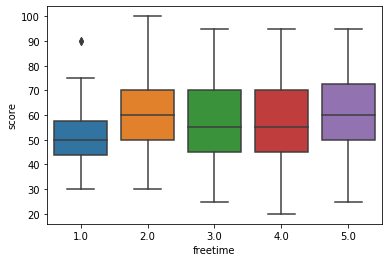

In [623]:
data.loc[(data['freetime'].isnull()), 'freetime'] = None
ttest_result = boxplot_ttest_choise(
    data, 'score', 'freetime', [1.0, 2.0, 3.0, 4.0, 5.0])

наличие свободного времени и его колличество никак не влияют на успеваемость. можно убрать столбец из дальнейшего рассмотрения. 

In [624]:
del data['freetime']

###  Проведение времени с друзьями

In [625]:
display(pd.DataFrame(data.goout.value_counts()))
data.loc[:, ['goout']].info()

,goout
3.0,127
2.0,101
4.0,84
5.0,52
1.0,23


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   goout   387 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Лишних данных нет. Nan меняем на None. все значения интересны для дальнейшего статистического анализа поэтому применяем сравнение t критерия стьюдента с соответствующей поправкой бонферони используя собственную функцию boxplot_ttest_choise

p-value: 0.0030448019; Значения 2.0 и 4.0 в колонке  goout достоверно различаются (alpha = 0.05)
p-value: 0.0043691505; Значения 2.0 и 5.0 в колонке  goout достоверно различаются (alpha = 0.05)


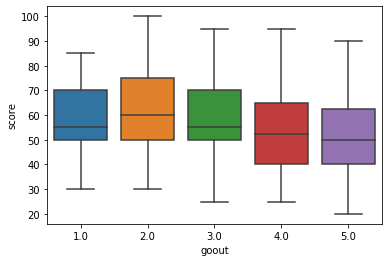

In [626]:
data.loc[(data['goout'].isnull()), 'goout'] = None
ttest_result = boxplot_ttest_choise(
    data, 'score', 'goout', [1.0, 2.0, 3.0, 4.0, 5.0])

Умеренное проведение времени (2.0) с друзьями положительно влияет на успешность сдачи экзамена (особенно в сравнении с теми кто много проводит вермени в прогулках). Параметр интересен для дальнейшего анализа.

### текущее состояние здоровья 

In [627]:
display(pd.DataFrame(data.health.value_counts()))
data.loc[:, ['health']].info()

,health
5.0,138
3.0,89
4.0,63
1.0,47
2.0,43


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   health  380 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Лишних данных нет. Nan меняем на None. все значения интересны для дальнейшего статистического анализа поэтому применяем сравнение t критерия стьюдента с соответствующей поправкой бонферони используя собственную функцию boxplot_ttest_choise

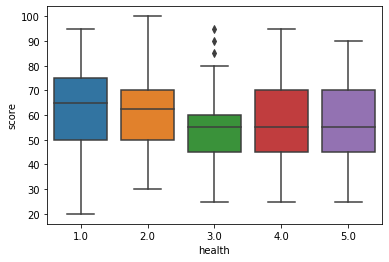

In [628]:
data.loc[(data['health'].isnull()), 'health'] = None
ttest_result = boxplot_ttest_choise(
    data, 'score', 'health', [1.0, 2.0, 3.0, 4.0, 5.0])

Состояние здоровья статистически не влияет на оценки (хотя по графикам кажется что все же в первых и вторых группах значения выше). Убираем из рассмотрения.

In [629]:
del data['health']

### отсутствие на уроках

,absences
0.0,111
2.0,60
4.0,53
6.0,31
8.0,21
10.0,17
12.0,12
14.0,12
3.0,8
16.0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   absences  383 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB

СТАТИСТИКИ и РЕЗУЛЬТАТЫ АНАЛИЗА ВЫБРОСОВ
медиана: 4.0, 25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


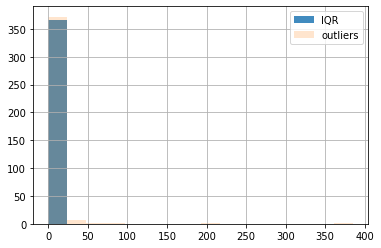

In [630]:
display(pd.DataFrame(data.absences.value_counts()))
data.loc[:, ['absences']].info()
data.absences = data.absences.apply(lambda x: none_insert(x))
stats_absences = outlier_quant(data, 'absences')

есть выбросы. необходимо их убрать.


СТАТИСТИКИ и РЕЗУЛЬТАТЫ АНАЛИЗА ВЫБРОСОВ
медиана: 4.0, 25-й перцентиль: 0.0, 75-й перцентиль: 7.0, IQR: 7.0,  Границы выбросов: [-10.5, 17.5].


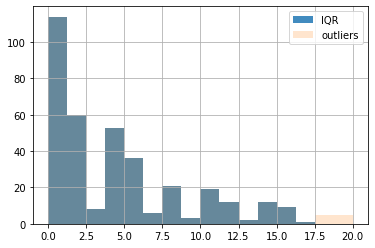

In [631]:
data.absences = data.absences.apply(
    lambda x: outliers_del(x, stats_absences[4], stats_absences[5]))
stats_absences = outlier_quant(data, 'absences')

## Этап 2 - корреляционный анализ.  

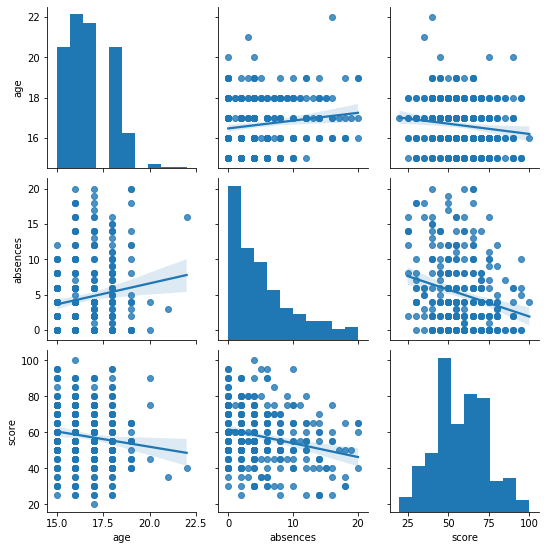

In [632]:
sns.pairplot(data[['age', 'absences', 'score']], kind='reg')

In [633]:
data[['age', 'absences', 'score']].corr()

,age,absences,score
age,1.000000,0.151493,-0.131542
absences,0.151493,1.000000,-0.242220
score,-0.131542,-0.242220,1.000000


Достоверных корреляций между численными значениями нет.

## Этап 3. проверка двойных номинативных колонок 

In [642]:
pair_column_ttest(data, ['school', 'sex', 'address', 'famsize', 'pstatus', 'famsup',
                         'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'], 'score')

p-value: 0.00427; в столбцах ('sex', 'address') значения ['F', 'R']  достоверно меньше значений ['M', 'U']
p-value: 0.00535; в столбцах ('sex', 'famsup') значения ['F', 'yes']  достоверно меньше значений ['M', 'yes']
p-value: 0.0002; в столбцах ('address', 'famsize') значения ['U', 'GT3']  достоверно больше значений ['R', 'GT3']
p-value: 0.00268; в столбцах ('address', 'famsize') значения ['U', 'LE3']  достоверно больше значений ['R', 'GT3']
p-value: 0.00129; в столбцах ('address', 'pstatus') значения ['U', 'T']  достоверно больше значений ['R', 'T']
p-value: 0.00599; в столбцах ('address', 'activities') значения ['U', 'yes']  достоверно больше значений ['R', 'yes']


Проверка попарных сравнений для двух групп не выявила дополнительных более сложных зависимостей для номинативных колонок где только два значения. Таки образом остаються только значения. пол адрес и поддержка школы. 

## Финальные заключения. 

1) Анализ номинативных данных (которых больше всего) с выбором из двух вариантов - (например да/нет) на данной выборке показал, что большинство таких данных не влияют на результаты оценок. Проверка более сложных переплетающихся связей на этапе 3 не дало дополнительных результатов (скорее всего, потому что для этого нужна более большая выборка). На существующей выборке удалось выяснить только достаточно логичные вещи - 1) мальчики более предрасположены (или больше интересуются) к математике и поэтому получают баллы больше 2) дети из города лучше сдают экзамены чем дети из поселков. Странным показался резульатат анализа дополнительной образовательной подержки - С высоким уровнем достоверности более высокие результаты тестов получают те кто не имеют дополнительной образовательной поддержки. Нужно пояснение что такое доп. образовательная поддержка. Возможно ее получают как раз те, кто очень слабые.  

2) Анализ номинативных данных где более 2 значений, кажутся более значимыми и полезными для анализа данных на данной выборке: в половине случаев были найдены значимые межгрупповые различия. Так к примеру положительно на оценки влияют - наличие высшего образование у матери и у отца, работа матери в сфере здравоохранения (странный результат - возможно в выборку попали в основном те кто работают врачами), работа отца учителем (логично, что успешные учителя ествественных наук чаще мужчины, может быть причина в этом). Отсутствиве внеучебных неудач, также положительно влияет на оценки. Трата умеренного времени на друзей положительно сказывается на оценки, сравнивая когда времени тратится много. Все эти признаки рекомендуется оставить для дальнейшего анализа. 

3) Корреляционный анализ не выявил достоверных корреляций между переменными. Все численные данные остаются для дальнейшего анализа.

4) Из настоящего анализа оценок были убраны оценки равные 0. Так как они явно выбиваются из этих данных. Причины их возникновения могут быть различны - за отсутствие ученика на экзамене могли поставить 0, ошибра при проверке (например неправильный вариант) и др. 

5) Данные довольно чистые - встречается достаточно мало отсутствующих значений (в сумме в среднем не более 5-10%). В группах в основном достаточное количество для проведения сравнительного статистического анализа 